In [8]:
import os
import copy
import pickle
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from dataset_wafer_trun import WaferDataset
from dataset_ecg200_trun import ECG200Dataset
from model import TransformerPredictor
from sklearn.metrics import average_precision_score as AUPRC
from sklearn.metrics import roc_auc_score as AUROC
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
def compute_metrics(y_true, y_prob):
    acc = 100*accuracy(y_true=y_true, y_pred=list(map(round, y_prob)))
    auprc = AUPRC(y_true=y_true, y_score=y_prob)
    auroc = AUROC(y_true=y_true, y_score=y_prob)
    bce = log_loss(y_true=y_true, y_pred=y_prob)
    return [acc, auprc, auroc, bce]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import copy
import pickle
from sklearn.metrics import average_precision_score as AUPRC
from sklearn.metrics import roc_auc_score as AUROC
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm


In [20]:
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("\n[1/5] Loading datasets...")
train_dataset_wafer = WaferDataset(root_dir="./data", mode="train",truncation=[0.2, 0.4, 0.6, 0.8],random_seed=0)
test_dataset_wafer = WaferDataset(root_dir="./data", mode="test",truncation=[0.2,0.4,0.6,0.8],random_seed=0)
train_dataset_ecg = ECG200Dataset(root_dir="./data", mode="train",truncation=[0.2,0.4,0.6,0.8,1],random_seed=0)
test_dataset_ecg = ECG200Dataset(root_dir="./data", mode="test",truncation=[0.2,0.4,0.6,0.8,1],random_seed=0)



[1/5] Loading datasets...


In [25]:
import torch
import numpy as np
ratio_counts = {}
for sample in test_dataset_ecg:
    trunc_ratio = sample.get("sql", 1.0)
    target = sample["target"]
    if isinstance(target, torch.Tensor):
        target = target.item()
    if trunc_ratio not in ratio_counts:
        ratio_counts[trunc_ratio] = {"pos": 0, "neg": 0}
    if target == 1:
        ratio_counts[trunc_ratio]["pos"] += 1
    else:
        ratio_counts[trunc_ratio]["neg"] += 1
print("Truncation Ratio Distribution:")
for ratio in sorted(ratio_counts.keys()):
    pos = ratio_counts[ratio]["pos"]
    neg = ratio_counts[ratio]["neg"]
    total = pos + neg
    pos_percentage = pos / total * 100 if total > 0 else 0
    neg_percentage = neg / total * 100 if total > 0 else 0
    print(f"Level {ratio}: Positive: {pos} ({pos_percentage:.2f}%), "
          f"Negative: {neg} ({neg_percentage:.2f}%), Total: {total}")


Truncation Ratio Distribution:
Level 28: Positive: 2627 (58.38%), Negative: 1873 (41.62%), Total: 4500
Level 56: Positive: 2627 (58.38%), Negative: 1873 (41.62%), Total: 4500
Level 84: Positive: 2627 (58.38%), Negative: 1873 (41.62%), Total: 4500
Level 112: Positive: 2627 (58.38%), Negative: 1873 (41.62%), Total: 4500
Level 140: Positive: 2627 (58.38%), Negative: 1873 (41.62%), Total: 4500


In [9]:
targets = np.array([sample["target"].item() for sample in train_dataset_wafer])
labels_unique, counts = np.unique(targets, return_counts=True)
class_weights = [sum(counts) / c for c in counts]
weights = [class_weights[x] for x in targets]


In [26]:
targets = np.array([sample["target"].item() for sample in train_dataset_ecg])
labels_unique, counts = np.unique(targets, return_counts=True)
class_weights = [sum(counts) / c for c in counts]
weights = [class_weights[x] for x in targets]


In [27]:
from transformers import get_linear_schedule_with_warmup
def train_model(dataset_class, dataset_name, sequence_length, batch_size=32, epochs=35,
                d_model=64, lr=1e-5, pooling="cls", n_trainings=10, patience=10, device='cuda' if torch.cuda.is_available() else 'cpu'):
    print(f"\n===== Training on {dataset_name} with pooling: {pooling} =====\n")
    set_seed(42)
    train_dataset = dataset_class(root_dir="./data", mode="train",truncation=[0.2,0.4,0.6,0.8,1],random_seed=0)
    test_dataset = dataset_class(root_dir="./data", mode="test",truncation=[0.2,0.4,0.6,0.8,1],random_seed=0)
    targets = np.array([sample["target"] for sample in train_dataset])
    class_weights = [sum(targets == 0) / len(targets), sum(targets == 1) / len(targets)]
    sample_weights = [class_weights[t] for t in targets]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    ensemble_results = []
    for i in range(n_trainings):
        set_seed(42 + i)
        print(f"\n=== Training Model {i+1}/{n_trainings} ===\n")
        model = TransformerPredictor(d_model=d_model, n_layers=4, dropout=0.2,
                                     pooling=pooling, sequence_length=sequence_length).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-8, eps=1e-8)
        warmup_steps = int(0.1 * epochs * len(train_loader))
        total_steps = epochs * len(train_loader)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
        )
        criterion = nn.BCEWithLogitsLoss().to(device)
        best_auroc = 0.0
        current_patience = 0
        best_model_dict = None
        for epoch in range(epochs):
            model.train()
            y_true_train, y_prob_train = [], []
            train_loss = 0.0
            torch.set_printoptions(threshold=10000)
            for batch in train_loader:
                optimizer.zero_grad()
                sequence = batch["sequence"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                target = batch["target"].float().to(device)
                output = model(sequence, attention_mask).squeeze()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                y_true_train.extend(target.cpu().numpy())
                y_prob_train.extend(torch.sigmoid(output).cpu().detach().numpy())
            train_loss /= len(train_loader)
            acc_train, auprc_train, auroc_train, bce_train = compute_metrics(y_true_train, y_prob_train)
            print(f"Epoch {epoch+1}: Train AUPRC {auprc_train:.4f}, AUROC {auroc_train:.4f}, BCE {bce_train:.4f}, Loss {train_loss:.4f}")
            scheduler.step()
            model.eval()
            y_true_test, y_prob_test = [], []
            test_loss = 0.0
            with torch.no_grad():
                for batch in test_loader:
                    sequence = batch["sequence"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    target = batch["target"].float().to(device)
                    output = model(sequence, attention_mask).squeeze()
                    loss = criterion(output, target)
                    test_loss += loss.item()
                    y_true_test.extend(target.cpu().numpy())
                    y_prob_test.extend(torch.sigmoid(output).cpu().numpy())
            test_loss /= len(test_loader)
            acc_test, auprc_test, auroc_test, bce_test = compute_metrics(y_true_test, y_prob_test)
            print(f"Epoch {epoch+1}: Test AUPRC {auprc_test:.4f}, Test AUROC {auroc_test:.4f}, Test BCE {bce_test:.4f}, Loss {test_loss:.4f}")
            if auroc_test > best_auroc:
                best_auroc = auroc_test
                best_model_dict = copy.deepcopy(model.state_dict())
                current_patience = 0
                print(f"🌟 New Best AUROC: {best_auroc:.4f} at epoch {epoch+1}")
            else:
                current_patience += 1
                print(f"⚠️ No AUROC improvement for {current_patience} epochs (Max: {patience})")
                if current_patience >= patience:
                    print(f"⏳ Early Stopping at epoch {epoch+1} (Best AUROC: {best_auroc:.4f})")
                    break
        if best_model_dict:
            model.load_state_dict(best_model_dict)
            model.eval()
            y_true_best, y_prob_best = [], []
            with torch.no_grad():
                for batch in test_loader:
                    sequence = batch["sequence"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    target = batch["target"].float().to(device)
                    output = model(sequence, attention_mask).squeeze()
                    y_true_best.extend(target.cpu().numpy())
                    y_prob_best.extend(torch.sigmoid(output).cpu().numpy())
            ensemble_results.append(y_prob_best)
        os.makedirs("results", exist_ok=True)
        with open(f"results/{dataset_name}_ensemble_{pooling}_trun.pkl", "wb") as f:
            pickle.dump(ensemble_results, f)
        print(f"\nEnsemble results saved for {dataset_name} with pooling {pooling}!")


In [ ]:
for pool,lr,ep in [("cls",1e-3,30),
                   ("mean_without_padding",1e-3,30)
                  ]:
    train_model(WaferDataset, "Wafer", sequence_length=152, pooling=pool, batch_size=32, epochs=ep,
                d_model=256, lr=lr, n_trainings=10, patience=50,)



===== Training on Wafer with pooling: cls =====


=== Training Model 1/10 ===

Epoch 1: Train AUPRC 0.9857, AUROC 0.4982, BCE 0.8818, Loss 0.8819
Epoch 1: Test AUPRC 0.9067, Test AUROC 0.5119, Test BCE 0.8714, Loss 0.8714
🌟 New Best AUROC: 0.5119 at epoch 1
Epoch 2: Train AUPRC 0.9833, AUROC 0.4719, BCE 0.4829, Loss 0.4827
Epoch 2: Test AUPRC 0.9046, Test AUROC 0.4961, Test BCE 0.3491, Loss 0.3491
⚠️ No AUROC improvement for 1 epochs (Max: 50)
Epoch 3: Train AUPRC 0.9863, AUROC 0.5158, BCE 0.1407, Loss 0.1406
Epoch 3: Test AUPRC 0.9063, Test AUROC 0.4957, Test BCE 0.3415, Loss 0.3415
⚠️ No AUROC improvement for 2 epochs (Max: 50)
Epoch 4: Train AUPRC 0.9851, AUROC 0.4853, BCE 0.0887, Loss 0.0887
Epoch 4: Test AUPRC 0.8931, Test AUROC 0.4732, Test BCE 0.3835, Loss 0.3835
⚠️ No AUROC improvement for 3 epochs (Max: 50)
Epoch 5: Train AUPRC 0.9870, AUROC 0.5377, BCE 0.0777, Loss 0.0777
Epoch 5: Test AUPRC 0.8935, Test AUROC 0.4836, Test BCE 0.4097, Loss 0.4097
⚠️ No AUROC improvement for 

In [ ]:
print(1)


In [28]:
for pool in ["cls","mean_without_padding"]:
    train_model(ECG200Dataset, "ECG200", sequence_length=140, pooling=pool,batch_size=256, epochs=30,
                d_model=128, lr=1e-3, n_trainings=10, patience=35)



===== Training on ECG200 with pooling: cls =====


=== Training Model 1/10 ===

Epoch 1: Train AUPRC 0.6386, AUROC 0.4894, BCE 0.6743, Loss 0.6740
Epoch 1: Test AUPRC 0.6570, Test AUROC 0.5619, Test BCE 0.6840, Loss 0.6842
🌟 New Best AUROC: 0.5619 at epoch 1
Epoch 2: Train AUPRC 0.7017, AUROC 0.5327, BCE 0.6443, Loss 0.6444
Epoch 2: Test AUPRC 0.7395, Test AUROC 0.6764, Test BCE 0.6904, Loss 0.6911
🌟 New Best AUROC: 0.6764 at epoch 2
Epoch 3: Train AUPRC 0.7497, AUROC 0.6097, BCE 0.6210, Loss 0.6197
Epoch 3: Test AUPRC 0.7186, Test AUROC 0.6752, Test BCE 0.6529, Loss 0.6534
⚠️ No AUROC improvement for 1 epochs (Max: 35)
Epoch 4: Train AUPRC 0.7866, AUROC 0.6555, BCE 0.6018, Loss 0.6010
Epoch 4: Test AUPRC 0.7456, Test AUROC 0.7154, Test BCE 0.6415, Loss 0.6421
🌟 New Best AUROC: 0.7154 at epoch 4
Epoch 5: Train AUPRC 0.8240, AUROC 0.7195, BCE 0.5724, Loss 0.5718
Epoch 5: Test AUPRC 0.7946, Test AUROC 0.7665, Test BCE 0.6030, Loss 0.6038
🌟 New Best AUROC: 0.7665 at epoch 5
Epoch 6: Trai


===== Training on Wafer with pooling: mean_without_padding =====



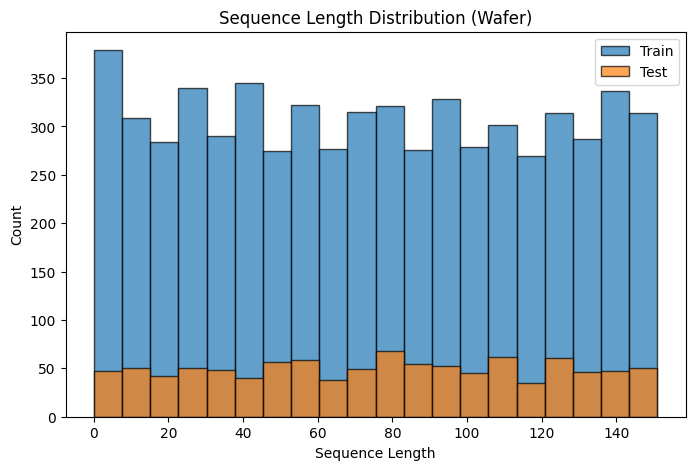


=== Training Model 1/10 ===

Epoch 1: Train AUPRC 0.9850, AUROC 0.5147, BCE 0.2759, Loss 0.2757
Epoch 1: Test AUPRC 0.9058, Test AUROC 0.5270, Test BCE 0.3224, Loss 0.3237
🌟 New Best Loss: inf at epoch 1
Epoch 2: Train AUPRC 0.9845, AUROC 0.4617, BCE 0.1561, Loss 0.1560
Epoch 2: Test AUPRC 0.8915, Test AUROC 0.4889, Test BCE 0.3230, Loss 0.3245
🌟 New Best Loss: inf at epoch 2
Epoch 3: Train AUPRC 0.9877, AUROC 0.5707, BCE 0.1305, Loss 0.1304
Epoch 3: Test AUPRC 0.8979, Test AUROC 0.4931, Test BCE 0.3258, Loss 0.3275
🌟 New Best Loss: inf at epoch 3
Epoch 4: Train AUPRC 0.9835, AUROC 0.4866, BCE 0.1243, Loss 0.1242
Epoch 4: Test AUPRC 0.8941, Test AUROC 0.4708, Test BCE 0.3265, Loss 0.3284
🌟 New Best Loss: inf at epoch 4
Epoch 5: Train AUPRC 0.9863, AUROC 0.4678, BCE 0.1133, Loss 0.1133
Epoch 5: Test AUPRC 0.9049, Test AUROC 0.5317, Test BCE 0.3362, Loss 0.3379
🌟 New Best Loss: inf at epoch 5
Epoch 6: Train AUPRC 0.9887, AUROC 0.5456, BCE 0.1096, Loss 0.1095
Epoch 6: Test AUPRC 0.8884, 

In [ ]:
train_model(WaferDataset, "Wafer", sequence_length=152, pooling="mean_without_padding")


In [46]:
poolings = ["cls", "mean_without_padding"]
truncations = [
               "100"]
seq_l=75
res_set = []
for pooling in poolings:
    try:
        with open(f'results/Wafer_ensemble_{pooling}_trun.pkl', 'rb') as f:
            sub_res = pickle.load(f)
    except FileNotFoundError:
        print(f"File model/ntrain_{pooling}_sq{seq_l}.pkl not found. Skipping.")
        continue
    res_set.append(pd.DataFrame(sub_res).T)


In [36]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
                             brier_score_loss)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
def compute_ece(y_true, y_prob, n_bins=10):
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower = bin_edges[i]
        bin_upper = bin_edges[i + 1]
        bin_mask = (y_prob > bin_lower) & (y_prob <= bin_upper)
        bin_count = np.sum(bin_mask)
        if bin_count > 0:
            bin_accuracy = np.mean(y_true[bin_mask] == 1)
            bin_confidence = np.mean(y_prob[bin_mask])
            ece += np.abs(bin_accuracy - bin_confidence) * (bin_count / len(y_true))
    return ece
def uncertainty_auroc(y, predictions, variance):
    y = np.array(y)
    predictions = np.array(predictions)
    variance = np.array(variance)
    correctness = (y == (predictions > 0.5))
    fprs, tprs, _ = roc_curve(correctness, -1 * variance)
    auc = roc_auc_score(correctness, -1 * variance)
    return tprs, fprs, auc
def calculate_ause(uncertainty, predictions, targets, metric='brier',
                   uncertainty_type='variance', bins=10, save_path=None, min_fraction=0.0,
                   max_fraction=0.9, ax=None, color='b', label='Sparsification Error'):
    if not (len(predictions) == len(targets) == len(uncertainty)):
        raise ValueError("predictions, targets, and uncertainty must have the same length.")
    if len(predictions) < 10:
        raise ValueError("Not enough predictions for sparsification.")
    def brier_score(preds, tgts):
        return np.mean((preds - tgts)**2)
    def mean_absolute_error(preds, tgts):
        return np.mean(np.abs(preds - tgts))
    def calculate_ece_metric(preds, tgts, n_bins=10):
        n = len(preds)
        if n == 0:
            return np.nan
        bin_edges = np.linspace(0., 1., n_bins + 1)
        bin_indices = np.digitize(preds, bin_edges, right=True) - 1
        ece = 0.0
        for i in range(n_bins):
            bin_mask = bin_indices == i
            bin_size = np.sum(bin_mask)
            if bin_size > 0:
                bin_confidence = np.mean(preds[bin_mask])
                bin_accuracy = np.mean(tgts[bin_mask])
                ece += (bin_size / n) * np.abs(bin_accuracy - bin_confidence)
        return ece
    def calculate_auc_metric(preds, tgts):
        if len(np.unique(tgts)) < 2:
            return np.nan
        return roc_auc_score(tgts, preds)
    if metric == 'brier':
        error_function = brier_score
    elif metric == 'mae':
        error_function = mean_absolute_error
    elif metric == 'ece':
        error_function = lambda p, t: calculate_ece_metric(p, t, n_bins=bins)
    elif metric == 'auc':
        error_function = calculate_auc_metric
    else:
        raise ValueError("Unknown metric. Choose from 'brier', 'mae', 'ece', or 'auc'.")
    sorted_inds_uncertainty = np.argsort(uncertainty)
    if metric in ['brier', 'mae']:
        if metric == 'brier':
            true_errors = (predictions - targets)**2
        else:
            true_errors = np.abs(predictions - targets)
        sorted_inds_error = np.argsort(true_errors)
    else:
        sorted_inds_error = None
    uncertainty_scores = []
    oracle_scores = []
    fractions = np.linspace(min_fraction, max_fraction, int((max_fraction - min_fraction)/0.01) + 1)
    num_samples = len(predictions)
    for fraction in fractions:
        num_keep = max(1, int((1.0 - fraction) * num_samples))
        inds_keep_uncertainty = sorted_inds_uncertainty[:num_keep]
        remaining_preds = predictions[inds_keep_uncertainty]
        remaining_targets = targets[inds_keep_uncertainty]
        try:
            uncertainty_error_score = error_function(remaining_preds, remaining_targets)
        except ValueError as e:
            print(f"Error calculating {metric} at fraction {fraction:.2f}: {e}")
            uncertainty_error_score = np.nan
        uncertainty_scores.append(uncertainty_error_score)
        if sorted_inds_error is not None:
            inds_keep_oracle = sorted_inds_error[:num_keep]
            oracle_preds = predictions[inds_keep_oracle]
            oracle_targets = targets[inds_keep_oracle]
            try:
                oracle_error_score = error_function(oracle_preds, oracle_targets)
            except ValueError as e:
                print(f"Error calculating Oracle {metric} at fraction {fraction:.2f}: {e}")
                oracle_error_score = np.nan
            oracle_scores.append(oracle_error_score)
        else:
            oracle_scores.append(np.nan)
    uncertainty_scores = np.array(uncertainty_scores)
    oracle_scores = np.array(oracle_scores)
    if metric in ['brier', 'mae']:
        uncertainty_scores_normalized = uncertainty_scores / uncertainty_scores[0]
        if sorted_inds_error is not None:
            oracle_scores_normalized = oracle_scores / oracle_scores[0]
        else:
            oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    elif metric == 'ece':
        uncertainty_scores_normalized = uncertainty_scores / uncertainty_scores[0]
        oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    elif metric == 'auc':
        uncertainty_scores_normalized = (1 - uncertainty_scores) / (1 - uncertainty_scores[0])
        oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    else:
        raise ValueError("Unknown metric.")
    ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    if metric in ['brier', 'mae', 'ece', 'auc']:
        ax.plot(fractions, uncertainty_scores_normalized, label=f"{label} (AUSE={ause_pred:.4f})", color=color)
    ax.set_xlabel("Fraction of removed samples")
    ax.set_ylabel(f"{metric.upper()} Error (Normalized)")
    ax.set_ylim([0, 1.5])
    ax.set_title('Sparsification Curve')
    ax.legend()
    ax.grid(True)
    if save_path:
        plt.savefig(save_path)
    elif ax is None:
        plt.show()
    return ause_pred


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss
)
from sklearn.calibration import calibration_curve
from scipy.stats import norm
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
def compute_ece(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    ece = np.abs(prob_true - prob_pred).mean()
    return ece
def shannon_entropy(p, epsilon=1e-10):
    p = np.clip(p, epsilon, 1 - epsilon)
    entropy = -p * np.log(p) - (1 - p) * np.log(1 - p)
    return entropy
def model_result_show(prob_df_set, y, df_names, truncation_labels, truncation_colors, metric='brier'):
    y = np.array(y).ravel()
    num_poolings = len(prob_df_set)
    num_truncations = len(truncation_labels)
    fig, axes = plt.subplots(num_poolings, 9, figsize=(54, 6 * num_poolings))
    if num_poolings == 1:
        axes = np.array([axes])
    metrics_records = []
    colors = truncation_colors
    for i in range(num_poolings):
        pooling_name = df_names[i]
        ax_var_density = axes[i][0]
        ax_unc_roc = axes[i][1]
        ax_calibration = axes[i][2]
        ax_normal_roc = axes[i][3]
        ax_sparsification = axes[i][4]
        ax_brier_density = axes[i][5]
        ax_entropy_density = axes[i][6]
        ax_nll_density = axes[i][7]
        ax_pred_prob_density = axes[i][8]
        for t_idx in range(num_truncations):
            df = prob_df_set[i][t_idx]
            df = np.array(df)
            trunc_name = truncation_labels[t_idx]
            predictions = np.mean(df, axis=1)
            variance = np.var(df, axis=1)
            std_dev = np.sqrt(variance)
            normal_fpr, normal_tpr, _ = roc_curve(y, predictions)
            normal_auc = roc_auc_score(y, predictions)
            unc_tpr, unc_fpr, unc_auc = uncertainty_auroc(y, predictions, variance)
            prob_true, prob_pred = calibration_curve(y, predictions, n_bins=10)
            ece_score = compute_ece(y, predictions)
            auprc = average_precision_score(y, predictions)
            brier = (y - predictions) ** 2
            epsilon = 1e-10
            nll = - y * np.log(predictions + epsilon) - (1 - y) * np.log(1 - predictions + epsilon)
            entropy_pred = shannon_entropy(predictions)
            residuals = y - predictions
            residual_var = residuals ** 2
            pred_prob_mean = np.mean(predictions)
            c = colors[t_idx]
            variance_1 = np.round(np.mean(variance), 5)
            sns.kdeplot(
                variance,
                ax=ax_var_density,
                label=f"{trunc_name} (avg_Var={variance_1})",
                fill=False,
                color=c
            )
            ax_unc_roc.plot(
                unc_fpr,
                unc_tpr,
                label=f"{trunc_name} (AUROC={unc_auc:.2f})",
                color=c
            )
            ax_calibration.plot(
                prob_pred,
                prob_true,
                marker="o",
                label=f"{trunc_name} (ECE={ece_score:.2f})",
                color=c
            )
            ax_normal_roc.plot(
                normal_fpr,
                normal_tpr,
                label=f"{trunc_name} (AUC={normal_auc:.2f})",
                color=c
            )
            ause = calculate_ause(
                uncertainty=variance,
                predictions=predictions,
                targets=y,
                metric=metric,
                min_fraction=0.0,
                max_fraction=0.9,
                ax=ax_sparsification,
                color=c,
                label=f"{trunc_name}"
            )
            sns.kdeplot(
                brier,
                ax=ax_brier_density,
                label=f"{trunc_name} (Mean Brier={np.mean(brier):.4f})",
                color=c
            )
            sns.kdeplot(
                entropy_pred,
                ax=ax_entropy_density,
                label=f"{trunc_name} (Mean Entropy={np.mean(entropy_pred):.4f})",
                color=c
            )
            sns.kdeplot(
                nll,
                ax=ax_nll_density,
                label=f"{trunc_name} (Mean NLL={np.mean(nll):.4f})",
                color=c
            )
            sns.kdeplot(
                predictions,
                ax=ax_pred_prob_density,
                label=f"{trunc_name} (Mean Pred={pred_prob_mean:.4f})",
                color=c
            )
            metrics_records.append({
                "pooling": pooling_name,
                "truncation": trunc_name,
                "normal_auc": normal_auc,
                "uncertainty_auc": unc_auc,
                "auprc": auprc,
                "ece": ece_score,
                "brier_score_mean": np.mean(brier),
                "entropy_mean": np.mean(entropy_pred),
                "nll_mean": np.mean(nll),
                "pred_prob_mean": pred_prob_mean,
                "ause": ause,
                "var":np.mean(variance)
            })
        ax_var_density.set_title(f"{pooling_name} Variance Density")
        ax_var_density.set_xlabel("Variance")
        ax_var_density.set_xlim([-0.001, 0.01])
        ax_var_density.legend()
        ax_unc_roc.set_title(f"{pooling_name} Uncertainty ROC")
        ax_unc_roc.set_xlabel("False Positive Rate")
        ax_unc_roc.set_ylabel("True Positive Rate")
        ax_unc_roc.plot([0, 1], [0, 1], '--', color='gray')
        ax_unc_roc.legend()
        ax_unc_roc.grid(True)
        ax_calibration.set_title(f"{pooling_name} Calibration Curve")
        ax_calibration.set_xlabel("Mean Predicted Probability")
        ax_calibration.set_ylabel("Actual Positive Proportion")
        ax_calibration.plot([0, 1], [0, 1], linestyle="--", color="gray")
        ax_calibration.legend()
        ax_normal_roc.set_title(f"{pooling_name} ROC Curve")
        ax_normal_roc.set_xlabel("False Positive Rate")
        ax_normal_roc.set_ylabel("True Positive Rate")
        ax_normal_roc.plot([0, 1], [0, 1], '--', color="gray")
        ax_normal_roc.legend()
        ax_normal_roc.grid(True)
        ax_sparsification.set_title(f"{pooling_name} Sparsification Curve (Metric: {metric.upper()})")
        ax_sparsification.set_ylim([-0.01, 1.05])
        ax_sparsification.legend()
        ax_sparsification.grid(True)
        ax_brier_density.set_title(f"{pooling_name} Brier Score Density Plot")
        ax_brier_density.set_xlabel("Brier Score")
        ax_brier_density.set_ylabel("Density")
        ax_brier_density.legend()
        ax_entropy_density.set_title(f"{pooling_name} Prediction Distribution Entropy Density Plot")
        ax_entropy_density.set_xlabel("Entropy")
        ax_entropy_density.set_ylabel("Density")
        ax_entropy_density.legend()
        ax_nll_density.set_title(f"{pooling_name} Negative Log-Likelihood (NLL) Density Plot")
        ax_nll_density.set_xlabel("NLL")
        ax_nll_density.set_ylabel("Density")
        ax_nll_density.legend()
        ax_pred_prob_density.set_title(f"{pooling_name} Predicted Probability Density Plot")
        ax_pred_prob_density.set_xlabel("Predicted Probability")
        ax_pred_prob_density.set_ylabel("Density")
        ax_pred_prob_density.legend()
    plt.tight_layout()
    plt.show()
    return pd.DataFrame(metrics_records)


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)
def model_result_show(
    prob_df_set,
    y,
    n,
    df_names,
    truncations,
    truncation_colors,
    metric='brier'
):
    y = np.array(y).ravel()
    n = np.array(n).ravel()
    num_poolings = len(prob_df_set)
    fig, axes = plt.subplots(num_poolings, 10, figsize=(60, 6 * num_poolings))
    if num_poolings == 1:
        axes = np.array([axes])
    metrics_records = []
    for i in range(num_poolings):
        pooling_name = df_names[i]
        df_full = prob_df_set[i]
        df_full = np.array(df_full)
        ax_var_density        = axes[i][0]
        ax_unc_roc           = axes[i][1]
        ax_calibration       = axes[i][2]
        ax_normal_roc        = axes[i][3]
        ax_sparsification    = axes[i][4]
        ax_brier_density     = axes[i][5]
        ax_entropy_density   = axes[i][6]
        ax_nll_density       = axes[i][7]
        ax_pred_prob_density = axes[i][8]
        ax_pr                = axes[i][9]
        for t_idx, t_val in enumerate(truncations):
            if t_idx == 0:
                mask = (n <= t_val)
            else:
                mask = (n > truncations[t_idx - 1]) & (n <= t_val)
            if not np.any(mask):
                continue
            sub_df = df_full[mask]
            sub_y  = y[mask]
            fraction_data = sub_df.shape[0] / df_full.shape[0]
            predictions = np.mean(sub_df, axis=1)
            variance = np.var(sub_df, axis=1)
            std_dev = np.sqrt(variance)
            normal_fpr, normal_tpr, _ = roc_curve(sub_y, predictions)
            normal_auc = roc_auc_score(sub_y, predictions)
            unc_tpr, unc_fpr, unc_auc = uncertainty_auroc(sub_y, predictions, variance)
            prob_true, prob_pred = calibration_curve(sub_y, predictions, n_bins=10)
            ece_score = compute_ece(sub_y, predictions)
            precision, recall, thresholds = precision_recall_curve(sub_y, predictions)
            auprc = average_precision_score(sub_y, predictions)
            brier = (sub_y - predictions) ** 2
            epsilon = 1e-10
            nll = -sub_y * np.log(predictions + epsilon) - (1 - sub_y) * np.log(1 - predictions + epsilon)
            entropy_pred = shannon_entropy(predictions)
            ause = calculate_ause(
                uncertainty=variance,
                predictions=predictions,
                targets=sub_y,
                metric=metric,
                min_fraction=0.0,
                max_fraction=0.9,
                ax=ax_sparsification,
                color=truncation_colors[t_idx],
                label=f"{t_val}"
            )
            variance_mean  = np.mean(variance)
            brier_mean     = np.mean(brier)
            entropy_mean   = np.mean(entropy_pred)
            nll_mean       = np.mean(nll)
            pred_prob_mean = np.mean(predictions)
            if t_idx == 0:
                trunc_name = f"≤ {t_val}"
            else:
                trunc_name = f"{truncations[t_idx - 1]}-{t_val}"
            c = truncation_colors[t_idx]
            sns.kdeplot(
                variance,
                ax=ax_var_density,
                label=f"{trunc_name} (avgVar={variance_mean:.5f}, ratio={fraction_data:.2f})",
                fill=False,
                color=c
            )
            ax_unc_roc.plot(
                unc_fpr,
                unc_tpr,
                label=f"{trunc_name} (AUROC={unc_auc:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            ax_calibration.plot(
                prob_pred,
                prob_true,
                marker="o",
                label=f"{trunc_name} (ECE={ece_score:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            ax_normal_roc.plot(
                normal_fpr,
                normal_tpr,
                label=f"{trunc_name} (AUC={normal_auc:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                brier,
                ax=ax_brier_density,
                label=f"{trunc_name} (MeanBrier={brier_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                entropy_pred,
                ax=ax_entropy_density,
                label=f"{trunc_name} (MeanEntropy={entropy_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                nll,
                ax=ax_nll_density,
                label=f"{trunc_name} (MeanNLL={nll_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                predictions,
                ax=ax_pred_prob_density,
                label=f"{trunc_name} (MeanPred={pred_prob_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            ax_pr.plot(
                recall,
                precision,
                marker='.',
                label=f"{trunc_name} (AUPRC={auprc:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            metrics_records.append({
                "pooling": pooling_name,
                "truncation": trunc_name,
                "ratio": fraction_data,
                "normal_auc": normal_auc,
                "uncertainty_auc": unc_auc,
                "auprc": auprc,
                "ece": ece_score,
                "brier_score_mean": brier_mean,
                "entropy_mean": entropy_mean,
                "nll_mean": nll_mean,
                "pred_prob_mean": pred_prob_mean,
                "ause": ause,
                "var_mean": variance_mean
            })
        ax_var_density.set_title(f"{pooling_name} - Variance Density")
        ax_var_density.set_xlabel("Variance")
        ax_var_density.legend()
        ax_unc_roc.set_title(f"{pooling_name} - Uncertainty ROC")
        ax_unc_roc.set_xlabel("False Positive Rate")
        ax_unc_roc.set_ylabel("True Positive Rate")
        ax_unc_roc.plot([0, 1], [0, 1], '--', color='gray')
        ax_unc_roc.legend()
        ax_unc_roc.grid(True)
        ax_calibration.set_title(f"{pooling_name} - Calibration Curve")
        ax_calibration.set_xlabel("Mean Predicted Probability")
        ax_calibration.set_ylabel("Actual Positive Proportion")
        ax_calibration.plot([0, 1], [0, 1], linestyle="--", color="gray")
        ax_calibration.legend()
        ax_normal_roc.set_title(f"{pooling_name} - ROC Curve")
        ax_normal_roc.set_xlabel("False Positive Rate")
        ax_normal_roc.set_ylabel("True Positive Rate")
        ax_normal_roc.plot([0, 1], [0, 1], '--', color="gray")
        ax_normal_roc.legend()
        ax_normal_roc.grid(True)
        ax_sparsification.set_title(f"{pooling_name} - Sparsification Curve (Metric: {metric.upper()})")
        ax_sparsification.set_ylim([-0.01, 1.05])
        ax_sparsification.legend()
        ax_sparsification.grid(True)
        ax_brier_density.set_title(f"{pooling_name} - Brier Score Density")
        ax_brier_density.set_xlabel("Brier Score")
        ax_brier_density.set_ylabel("Density")
        ax_brier_density.legend()
        ax_entropy_density.set_title(f"{pooling_name} - Prediction Dist. Entropy Density")
        ax_entropy_density.set_xlabel("Entropy")
        ax_entropy_density.set_ylabel("Density")
        ax_entropy_density.legend()
        ax_nll_density.set_title(f"{pooling_name} - Negative Log-Likelihood (NLL) Density")
        ax_nll_density.set_xlabel("NLL")
        ax_nll_density.set_ylabel("Density")
        ax_nll_density.legend()
        ax_pred_prob_density.set_title(f"{pooling_name} - Predicted Probability Density")
        ax_pred_prob_density.set_xlabel("Predicted Probability")
        ax_pred_prob_density.set_ylabel("Density")
        ax_pred_prob_density.legend()
        ax_pr.set_title(f"{pooling_name} - Precision-Recall Curve")
        ax_pr.set_xlabel("Recall")
        ax_pr.set_ylabel("Precision")
        ax_pr.set_xlim([0.0, 1.0])
        ax_pr.set_ylim([0.0, 1.05])
        ax_pr.legend()
        ax_pr.grid(True)
    plt.tight_layout()
    plt.show()
    metrics_df = pd.DataFrame(metrics_records)
    return metrics_df


In [50]:
balanced_val_lengths = [sample["truncation_ratio"] for sample in test_dataset_wafer]
y_val_int = np.array([sample["target"] for sample in test_dataset_wafer])


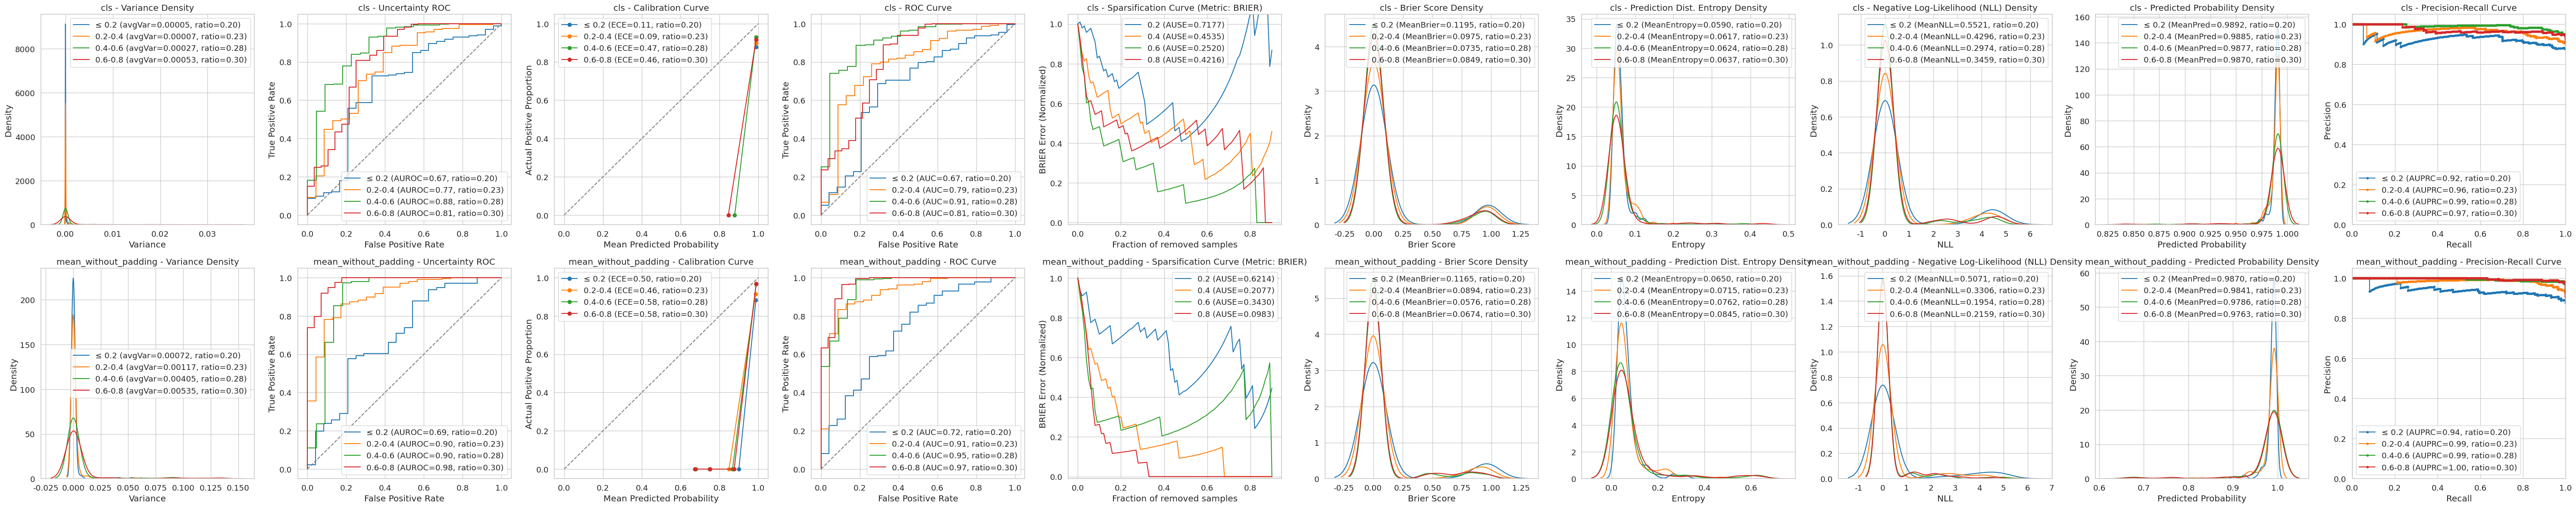

In [51]:
truncations=[0.2,0.4,0.6,0.8]
truncation_colors= sns.color_palette("tab10", n_colors=len(truncations))
data=model_result_show(
    res_set,
    y_val_int,
    balanced_val_lengths,
    poolings,
    truncations,
    truncation_colors,
    metric='brier'
)


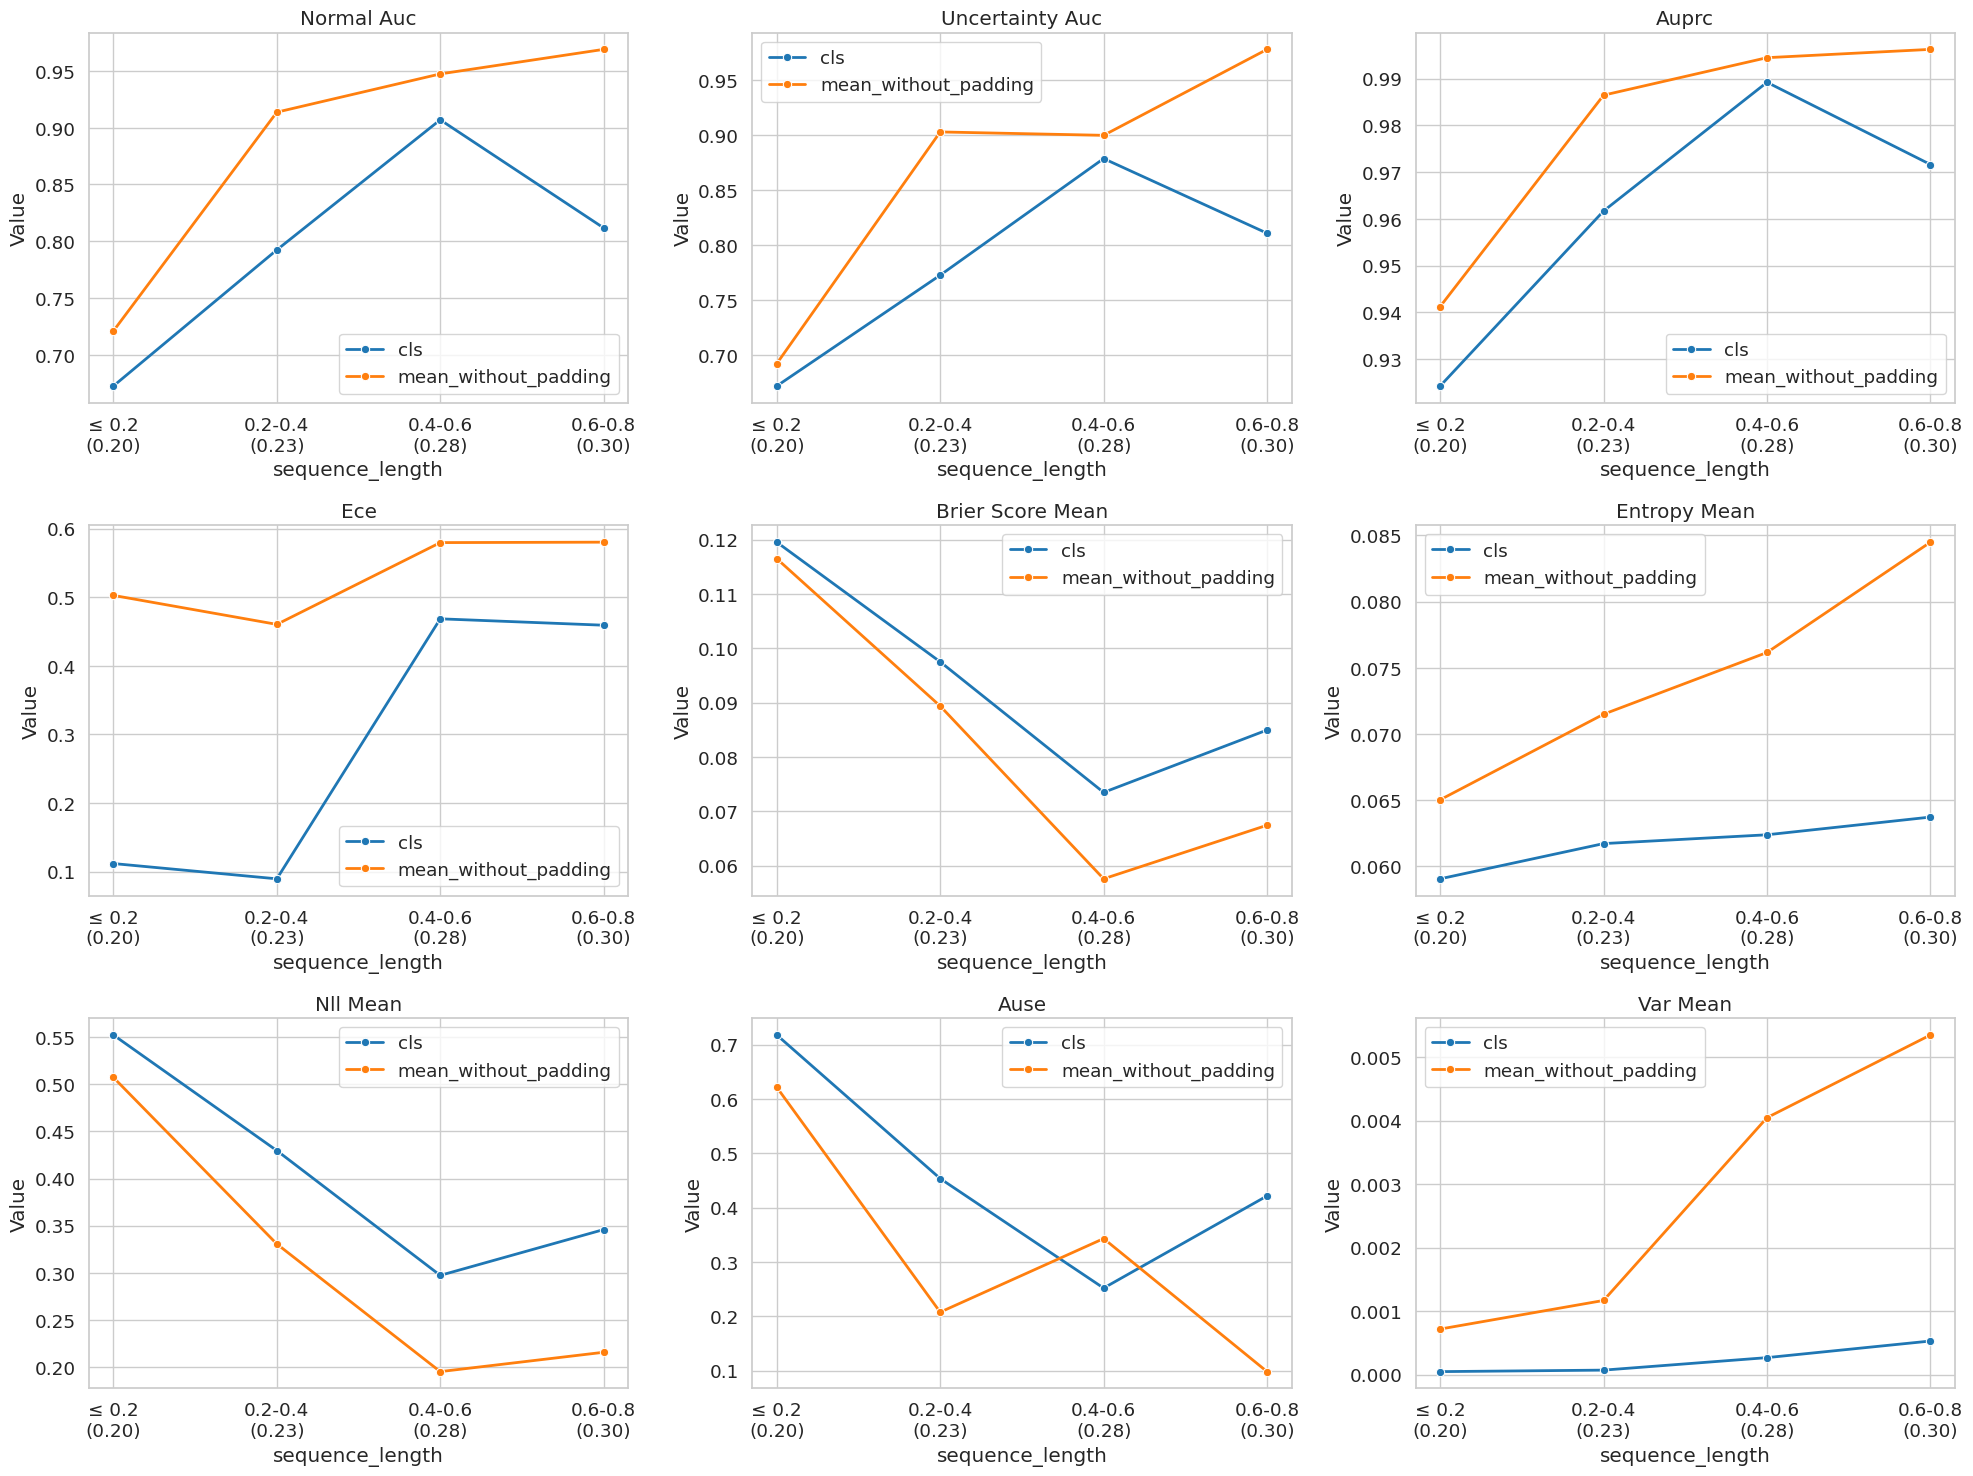

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(data)
truncation_ratio_dict = df.groupby('truncation')['ratio'].first().to_dict()
metrics = df.columns.to_list()[3:10] + df.columns.to_list()[11:]
df_melted = df.melt(
    id_vars=['pooling', 'truncation'],
    value_vars=metrics,
    var_name='metric',
    value_name='value'
)
sns.set(style="whitegrid", font_scale=1.2)
unique_metrics = df_melted['metric'].unique()
unique_poolings = df_melted['pooling'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_poolings))
color_dict = dict(zip(unique_poolings, palette))
num_metrics = len(unique_metrics)
num_cols = 3
num_rows = int(np.ceil(num_metrics / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()
for idx, metric in enumerate(unique_metrics):
    ax = axes[idx]
    data_metric = df_melted[df_melted['metric'] == metric]
    for pooling in unique_poolings:
        data_pooling = data_metric[data_metric['pooling'] == pooling]
        sns.lineplot(
            data=data_pooling,
            x='truncation',
            y='value',
            marker='o',
            label=pooling,
            color=color_dict[pooling],
            ax=ax,
            linewidth=2
        )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('sequence_length')
    ax.set_ylabel('Value')
    ax.legend()
    current_ticklabels = ax.get_xticklabels()
    new_labels = []
    for lbl in current_ticklabels:
        text = lbl.get_text()
        if text in truncation_ratio_dict:
            ratio_val = truncation_ratio_dict[text]
            new_label = f"{text}\n({ratio_val:.2f})"
        else:
            new_label = text
        new_labels.append(new_label)
    ax.set_xticklabels(new_labels)
for j in range(len(unique_metrics), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


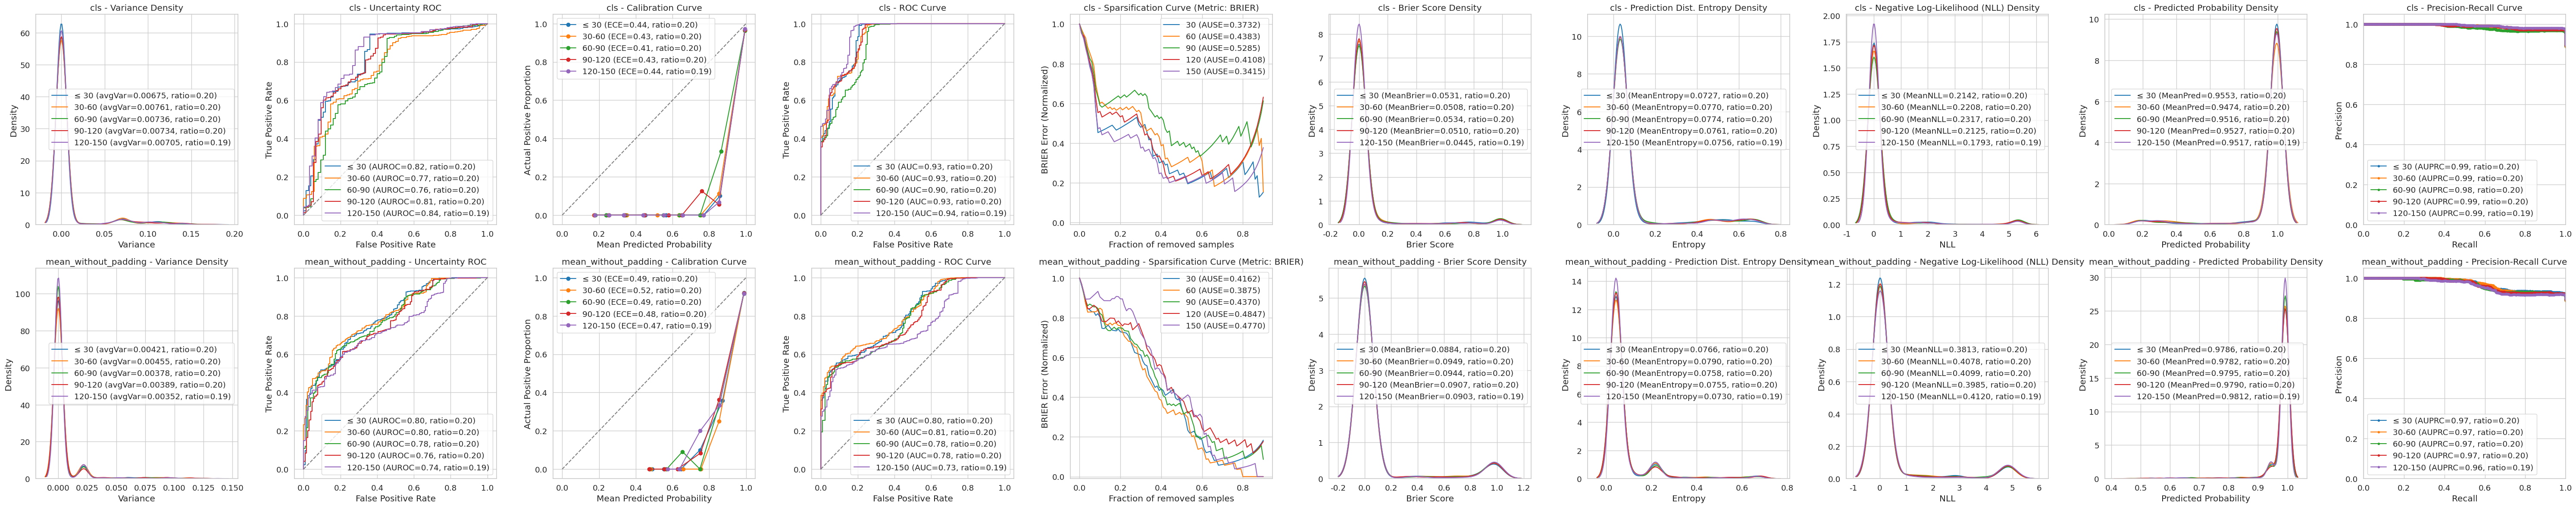

In [71]:
truncations=[30,60,90,120,150]
truncation_colors= sns.color_palette("tab10", n_colors=len(truncations))
data=model_result_show(
    res_set,
    y_val_int,
    balanced_val_lengths,
    poolings,
    truncations,
    truncation_colors,
    metric='brier'
)


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(data)
truncation_ratio_dict = df.groupby('truncation')['ratio'].first().to_dict()
metrics = df.columns.to_list()[3:10] + df.columns.to_list()[11:]
df_melted = df.melt(
    id_vars=['pooling', 'truncation'],
    value_vars=metrics,
    var_name='metric',
    value_name='value'
)
sns.set(style="whitegrid", font_scale=1.2)
unique_metrics = df_melted['metric'].unique()
unique_poolings = df_melted['pooling'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_poolings))
color_dict = dict(zip(unique_poolings, palette))
num_metrics = len(unique_metrics)
num_cols = 3
num_rows = int(np.ceil(num_metrics / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()
for idx, metric in enumerate(unique_metrics):
    ax = axes[idx]
    data_metric = df_melted[df_melted['metric'] == metric]
    for pooling in unique_poolings:
        data_pooling = data_metric[data_metric['pooling'] == pooling]
        sns.lineplot(
            data=data_pooling,
            x='truncation',
            y='value',
            marker='o',
            label=pooling,
            color=color_dict[pooling],
            ax=ax,
            linewidth=2
        )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('sequence_length')
    ax.set_ylabel('Value')
    ax.legend()
    current_ticklabels = ax.get_xticklabels()
    new_labels = []
    for lbl in current_ticklabels:
        text = lbl.get_text()
        if text in truncation_ratio_dict:
            ratio_val = truncation_ratio_dict[text]
            new_label = f"{text}\n({ratio_val:.2f})"
        else:
            new_label = text
        new_labels.append(new_label)
    ax.set_xticklabels(new_labels)
for j in range(len(unique_metrics), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


NameError: name 'data' is not defined

In [23]:
poolings = ["cls", "mean_without_padding"]
truncations = [
               "100"]
seq_l=75
res_set = []
for pooling in poolings:
    try:
        with open(f'results/ECG200_ensemble_{pooling}_trun.pkl', 'rb') as f:
            sub_res = pickle.load(f)
    except FileNotFoundError:
        print(f"File model/ECG200_{pooling}_sq{seq_l}.pkl not found. Skipping.")
        continue
    res_set.append(pd.DataFrame(sub_res).T)


In [24]:
res_set[0]


0         1         2         3         4         5         6  \
0      0.680554  0.732025  0.920017  0.788343  0.638196  0.754447  0.965958   
1      0.893788  0.763373  0.884988  0.937570  0.750410  0.656747  0.966407   
2      0.976636  0.973712  0.977723  0.973357  0.964691  0.958029  0.981977   
3      0.978677  0.979759  0.980496  0.980425  0.978133  0.975010  0.982459   
4      0.979601  0.974175  0.978898  0.969165  0.980143  0.970230  0.982133   
...         ...       ...       ...       ...       ...       ...       ...   
17995  0.010960  0.013075  0.008290  0.009887  0.013975  0.014236  0.010993   
17996  0.979884  0.953227  0.974192  0.975366  0.976498  0.972439  0.980313   
17997  0.979322  0.975124  0.967505  0.956955  0.970941  0.962180  0.972795   
17998  0.979162  0.973142  0.978407  0.940783  0.968861  0.976631  0.971592   
17999  0.861029  0.959202  0.948925  0.907441  0.974296  0.961115  0.973177   

              7         8         9  
0      0.916968  0.956071  0.405750  
1      0.541301  0.964376  0.323630  
2      0.973848  0.972651  0.951744  
3      0.973816  0.973128  0.968009  
4      0.900901  0.975511  0.966268  
...         ...       ...       ...  
17995  0.010310  0.016531  0.012776  
17996  0.978091  0.973737  0.961908  
17997  0.958173  0.975340  0.820638  
17998  0.977502  0.975979  0.962766  
17999  0.753422  0.972153  0.546703  

[18000 rows x 10 columns]

In [22]:
poolings = ["cls", "mean_without_padding"]
truncations = [
               "100"]
seq_l=75
res_set = []
for pooling in poolings:
    try:
        with open(f'results/ECG200_ensemble_{pooling}_trun.pkl', 'rb') as f:
            sub_res = pickle.load(f)
    except FileNotFoundError:
        print(f"File model/ECG200_{pooling}_sq{seq_l}.pkl not found. Skipping.")
        continue
    res_set.append(pd.DataFrame(sub_res).T)
balanced_val_lengths = [sample["truncation_ratio"] for sample in test_dataset_ecg]
y_val_int = np.array([sample["target"] for sample in test_dataset_ecg])
truncations=[0.2,0.4,0.6,0.8]
truncation_colors= sns.color_palette("tab10", n_colors=len(truncations))
data=model_result_show(
    res_set,
    y_val_int,
    balanced_val_lengths,
    poolings,
    truncations,
    truncation_colors,
    metric='brier'
)


KeyError: 'truncation_ratio'

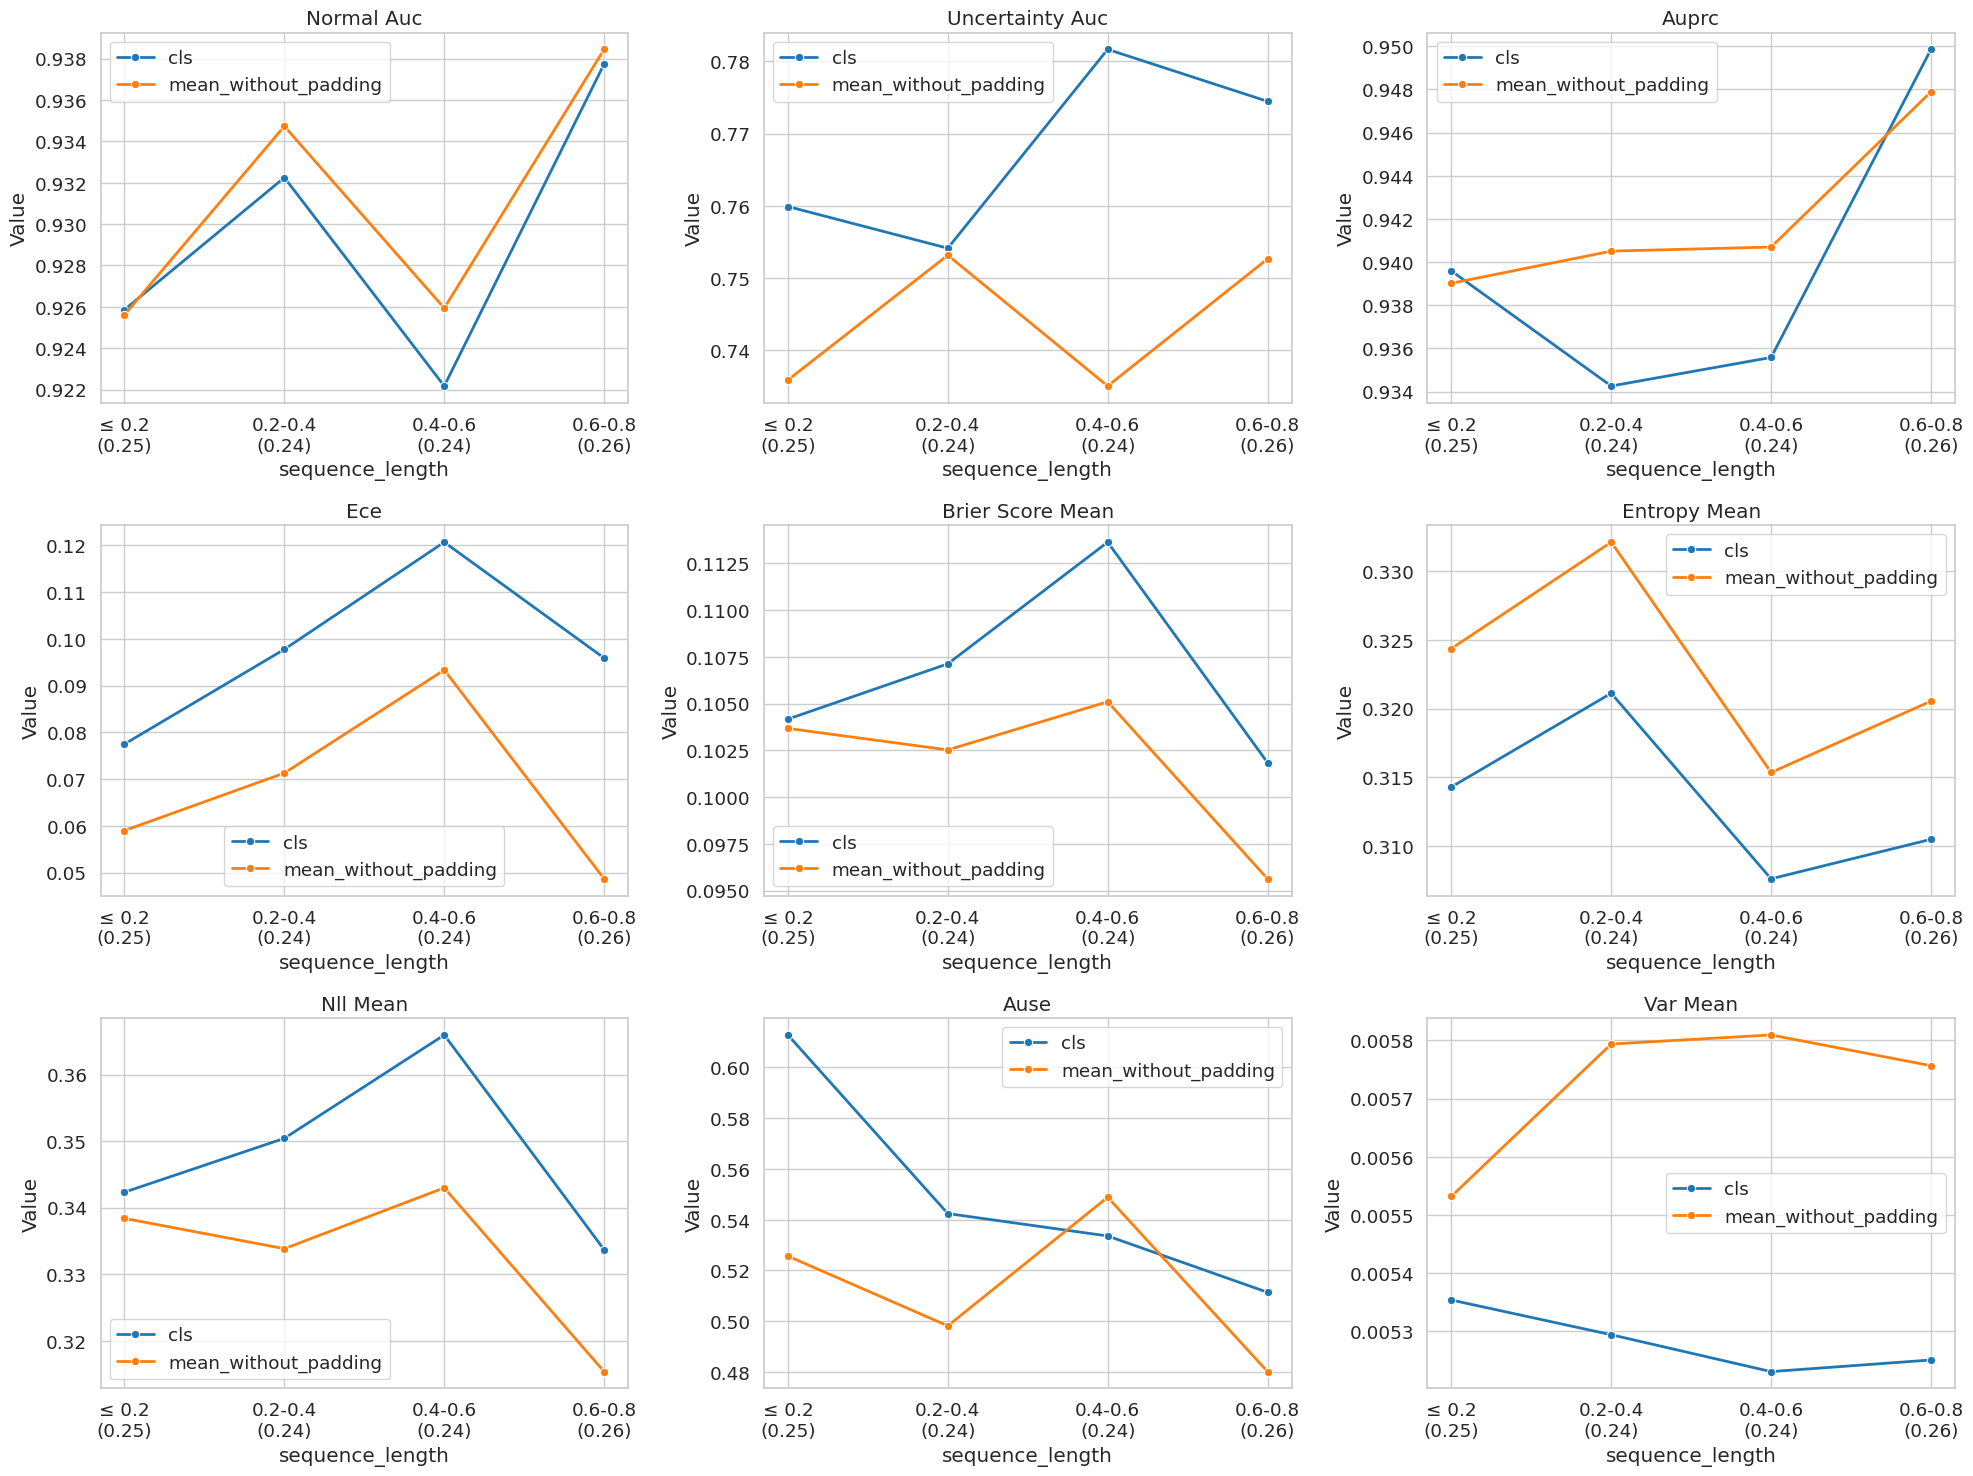

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(data)
truncation_ratio_dict = df.groupby('truncation')['ratio'].first().to_dict()
metrics = df.columns.to_list()[3:10] + df.columns.to_list()[11:]
df_melted = df.melt(
    id_vars=['pooling', 'truncation'],
    value_vars=metrics,
    var_name='metric',
    value_name='value'
)
sns.set(style="whitegrid", font_scale=1.2)
unique_metrics = df_melted['metric'].unique()
unique_poolings = df_melted['pooling'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_poolings))
color_dict = dict(zip(unique_poolings, palette))
num_metrics = len(unique_metrics)
num_cols = 3
num_rows = int(np.ceil(num_metrics / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()
for idx, metric in enumerate(unique_metrics):
    ax = axes[idx]
    data_metric = df_melted[df_melted['metric'] == metric]
    for pooling in unique_poolings:
        data_pooling = data_metric[data_metric['pooling'] == pooling]
        sns.lineplot(
            data=data_pooling,
            x='truncation',
            y='value',
            marker='o',
            label=pooling,
            color=color_dict[pooling],
            ax=ax,
            linewidth=2
        )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('sequence_length')
    ax.set_ylabel('Value')
    ax.legend()
    current_ticklabels = ax.get_xticklabels()
    new_labels = []
    for lbl in current_ticklabels:
        text = lbl.get_text()
        if text in truncation_ratio_dict:
            ratio_val = truncation_ratio_dict[text]
            new_label = f"{text}\n({ratio_val:.2f})"
        else:
            new_label = text
        new_labels.append(new_label)
    ax.set_xticklabels(new_labels)
for j in range(len(unique_metrics), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()
